<div style="text-align: center;">
    <h1>Group 34</h1>
</div>


<div style="text-align: center;">

# MACHINE LEARNING PROJECT
## Deliverable #1

**<h3 align="center">CARS 4 YOU</h3>**

<span style="font-size: 24px;">Master in Data Science and Advanced Analytics</span>  
<span style="font-size: 24px;">NOVA Information Management School</span>  
<span style="font-size: 20px;"><i>Group 34</i></span>  
<span style="font-size: 20px;">Fall/Spring Semester 2025-2026</span>

</div>

---

**Carolina Luz** | 20250409 | [20250409@novaims.unl.pt](mailto:20250409@novaims.unl.pt) <br>
**Margarida Quintino** | 20250411 | [20250411@novaims.unl.pt](mailto:20250411@novaims.unl.pt) <br>
**Pedro Castro** | 20250467 | [20250467@novaims.unl.pt](mailto:20250467@novaims.unl.pt)  <br>
**Pedro Carrasqueira** | 20250488 | [20250488@novaims.unl.pt](mailto:20250488@novaims.unl.pt)  


## 1. Project Setup

### 1.1 - Import libraries

In [1]:
# to ensure we can import category_encoders
#!pip install category_encoders==2.8.1

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# data partition / model evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

# pipelines and preprocessing (for Target Encoding)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# regression model
from sklearn.linear_model import Lasso

# target encoding
#import category_encoders as ce  

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### 1.2 - Load data

In [2]:
#Loading the original
train_data_og= pd.read_csv("train.csv")
test_data_og = pd.read_csv("test.csv")

# Keeping a copy
train_data = train_data_og.copy()
test_data = test_data_og.copy()

# Check for missing values in the 'carID' column
print(f" Missing values in 'carID': {train_data['carID'].isna().sum()}")

# Verify duplicate values on 'carID'
print(f" Duplicate values in 'carID': {train_data['carID'].duplicated().sum()}")

# Set index to carID
train_data = pd.DataFrame(train_data).set_index('carID')
train_data.head()

 Missing values in 'carID': 0
 Duplicate values in 'carID': 0


,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


## 2 - Metadata

### Index
* `carID`: An attribute that contains an identifier for each car.

### Categorical Data
* `Brand`: year mileage The car’s main brand (e.g. Ford, Toyota)
* `model`: The car model
* `transmission`: The type of transmission (Manual or Automatic)
* `fuelType`: Type of Fuel used by the car (Diesel, Petrol, Hybrid,Electric)
* `hasDamage`: Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.

### Numerical Data
* `price`: The car’s price when purchased by Cars 4 You (in £).  
* `year`: The year of Registration of the Car
* `mileage`: The total reported distance travelled by the car (in miles)
* `tax`: The amount of road tax (in £) that, in 2020, was applicable to the car in question.
* `mpg`: Average Miles per Gallon
* `engineSize`: Size of Engine in liters (Cubic Decimeters)
* `paintQuality%`: The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).
* `previousOwners`: Number of previous registered owners of the vehicle.

## 3 - Splitting the data

We will now split our train_data into a new, smaller training set and a validation set.

This is a critical step because we cannot use the test_data to evaluate our model (as we don't have the answers). By creating our own "practice test" (the validation set), we can reliably measure our model's performance, tune its parameters, and check for issues like overfitting before we generate our final submission.

In [3]:
# Defined globally for consistency
RSEED = 42

X = train_data.drop(columns=['price'])
y = train_data['price']

# Splitting the data into training and validation sets
# Reduced test_size to 0.2 (More training data = better model)
# Aligned random_state with global RSEED
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RSEED, 
    shuffle=True
)

print(f"Training Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")

Training Shape: (60778, 12)
Validation Shape: (15195, 12)


## 4 - Data Cleaning

This section represents a significant **optimization and refactoring** of the exploratory data cleaning performed in Deliverable 1. 

While the first deliverable relied on manual, scattered operations to identify issues, this pipeline consolidates that logic into a robust, production-ready system. The code is structured into three main phases: **Configuration**, **Deterministic Cleaning**, and **Statistical Imputation**.

#### __1. Configuration (Dictionary Mappings)__
We defined global dictionaries (`brand_map`, `transmission_map`, etc.) at the start of the script.
* **What it does:** Maps various typos (e.g., "vw", "v") and abbreviations to standard categories.
* **Why:** Defining these globally ensures consistency and makes the code easier to maintain. If we find a new typo, we only need to update the dictionary in one place, rather than hunting through multiple cells.

#### __2. Deterministic Cleaning__
This function handles "row-level" cleaning - fixes that do not depend on other data points, such as:
* **String Standardization:** Converts all text to lowercase and strips whitespace before applying the mapping dictionaries.
* **Negative Value Handling:** Physically impossible values (e.g., negative mileage) are converted to `NaN`. This treats them as "missing info" rather than valid outliers.
* **Temporal Logic Check (Future Data):** The provided database is from 2020. Therefore, any car with a model year > 2020 represents synthetic error or noise. We convert these to `NaN` to be imputed with the median year (2017), preserving the dataset's temporal integrity.
* **Type Casting:** Rounds the `year` and ensures `previousOwners` are integers, enforcing data type consistency.

#### __3. Statistical Imputation__
This function handles the missing values (`NaN`) generated in the previous step.
* **Leakage Prevention:** In order to avoid data leakage, this function strictly learns parameters (Median, Mode, KNN structure) from `X_train` and applies them to `X_val`.
* **Strategies:**
    * **Median:** Used for `year`, `mileage`, and `engineSize` because they are skewed (median is robust to outliers).
    * **KNN Imputer:** Used for `tax` and `mpg`. Since these correlate with `engineSize` and `year`, KNN provides a more accurate, context-aware guess than a simple average.
    * **Random Sampling:** Used for `paintQuality%` to preserve its original distribution variance, which mean/median imputation would destroy.
    * **Mode & Constants:** Used for categorical variables (`previousOwners`, `Brand`, `hasDamage`) where the most frequent value or a default ("unknown"/"0") is the safest statistical assumption.

#### __4. Execution Pipeline & Data Safety__
The final block executes the functions in order, creating a flow of new variables (`X_train_final`) rather than overwriting the original data.

* **Pipeline Flow:** `Raw Data` $\to$ `X_train_clean` (Deterministic) $\to$ `X_train_final` (Imputed).
* **Why we do not overwrite variables:**
    * **Idempotency:** Ensures that re-running a notebook cell does not accidentally corrupt the data (e.g., applying a transformation twice).
    * **Validation:** Preserving the original `X_train` allows us to create "Before vs. After" visualizations to verify our cleaning logic.
    * **Safety:** If a bug occurs in the cleaning function, the raw data remains intact in memory, avoiding the need to reload the dataset from disk.

In [4]:
# 1. CONFIGURATION (DICTIONARY MAPPINGS)
# These dictionaries normalize variations (typos, abbreviations) into standard categories.
# Defined globally for easy maintenance.

brand_map = {
    'for': 'ford', 'ord': 'ford', 'or': 'ford',
    'ercedes': 'mercedes', 'mercede': 'mercedes', 'ercede': 'mercedes',
    'vw': 'volkswagen', 'v': 'volkswagen', 'w': 'volkswagen',
    'ope': 'opel', 'pel': 'opel', 'pe': 'opel',
    'mw': 'bmw', 'bm': 'bmw',
    'aud': 'audi', 'udi': 'audi', 'ud': 'audi',
    'oyota': 'toyota', 'toyot': 'toyota',
    'koda': 'skoda', 'skod': 'skoda', 'kod': 'skoda',
    'yundai': 'hyundai', 'hyunda': 'hyundai', 'yunda': 'hyundai'
}

transmission_map = {
    'anual': 'manual', 'manua': 'manual', 'anua': 'manual',
    'semi-aut': 'semi-auto', 'emi-aut': 'semi-auto', 'emi-auto': 'semi-auto',
    'automati': 'automatic', 'utomatic': 'automatic', 'utomati': 'automatic',
    'nknown': 'unknown', 'nknow': 'unknown', 'unknow': 'unknown'
}

fueltype_map = {
    'etrol': 'petrol', 'petro': 'petrol', 'etro': 'petrol',
    'iesel': 'diesel', 'diese': 'diesel', 'iese': 'diesel',
    'ybri': 'hybrid', 'hybri': 'hybrid', 'ybrid': 'hybrid',
    'ther': 'other', 'othe': 'other'
}

model_map = {
    'tigua': 'tiguan', 't-ro': 't-roc', 'tiguan allspac': 'tiguan allspace',
    'astr': 'astra', 'fiest': 'fiesta', 'insigni': 'insignia',
    'octavi': 'octavia', 'monde': 'mondeo', 'passa': 'passat',
    'edg': 'edge', 'mokk': 'mokka', 'arteo': 'arteon',
    'aur': 'auris', 'fabi': 'fabia', 'ayg': 'aygo',
    'gol': 'golf', 'coroll': 'corolla', 'zafir': 'zafira',
    'c-ma': 'c-max', 'grand c-ma': 'grand c-max', 'b-ma': 'b-max',
    'yeti outdoo': 'yeti outdoor', 'grand tourneo connec': 'grand tourneo connect'
}

# 2. DETERMINISTIC CLEANING FUNCTION

def clean_features(df):
    """
    Performs deterministic row-level cleaning. 
    This function fixes typos, standardizes strings, and handles invalid values (negatives/future years).
    It does NOT look at other rows, so it is safe to run on Train and Test independently.

    Args:
        df (pd.DataFrame): The raw input dataframe (X_train or X_val).

    Returns:
        pd.DataFrame: A cleaned dataframe with standardized strings and NaNs where invalid values existed.
    """
    df = df.copy()
    
    # A. String Standardization
    # Lowers case, strips whitespace, and applies the dictionary maps defined above.
    for col, mapping in [('Brand', brand_map), ('transmission', transmission_map), 
                         ('fuelType', fueltype_map), ('model', model_map)]:
        df[col] = df[col].str.lower().str.strip()
        df[col] = df[col].replace(mapping)

    # B. Negative Value Handling
    # Physical quantities (mileage, tax, etc.) cannot be negative.
    # We convert negatives to NaN using vectorized .loc for performance.
    cols_to_check = ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners']
    for col in cols_to_check:
        if col in df.columns:
            df.loc[df[col] < 0, col] = np.nan

    # C. Type Casting & Logic Fixes
    # Year: Round to nearest integer
    if 'year' in df.columns:
        df['year'] = np.round(df['year'])
        
        # LOGIC FIX: The Database is from 2020. 
        # Any car with year > 2020 is a data error (leakage/noise).
        # We treat these as "Missing" so they get imputed with the Median (e.g., 2017).
        df.loc[df['year'] > 2020, 'year'] = np.nan
        
        # Convert to nullable Int64
        df['year'] = df['year'].astype('Int64')

    # Previous Owners: Must be integers. 
    # If a value is 1.5, it makes no sense -> Convert to NaN.
    if 'previousOwners' in df.columns:
        df.loc[df['previousOwners'] % 1 != 0, 'previousOwners'] = np.nan
        df['previousOwners'] = df['previousOwners'].astype('Int64')

    return df


# 3. STATISTICAL IMPUTATION FUNCTION

def impute_missing_data(X_train, X_val):
    """
    Fills missing values using statistical methods.
    CRITICAL: All statistics (Median, KNN, Mode) are learned from X_train ONLY 
    and applied to X_val to prevent Data Leakage.

    Args:
        X_train (pd.DataFrame): The training features (used to learn the stats).
        X_val (pd.DataFrame): The validation features (transformed using X_train stats).

    Returns:
        tuple: (X_train_filled, X_val_filled) - Dataframes with no missing values.
    """
    X_train = X_train.copy()
    X_val = X_val.copy()

    # A. Simple Median Imputation
    # For robust features, median is safer than mean.
    cols_median = ['year', 'mileage', 'engineSize']
    medians = X_train[cols_median].median()
    
    X_train[cols_median] = X_train[cols_median].fillna(medians)
    X_val[cols_median] = X_val[cols_median].fillna(medians)

    # B. KNN Imputation (Multivariate)
    # Used for 'tax' and 'mpg' as they likely correlate with engineSize/year/mileage.
    # We must Scale first because KNN is distance-based.
    knn_cols = ['year', 'mileage', 'engineSize', 'tax', 'mpg']
    
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=5)
    
    # 1. Fit & Transform Train
    train_scaled = scaler.fit_transform(X_train[knn_cols])
    train_imputed = imputer.fit_transform(train_scaled)
    train_final = scaler.inverse_transform(train_imputed)
    
    # 2. Transform Validation (Using Train's scaler and imputer logic)
    val_scaled = scaler.transform(X_val[knn_cols])
    val_imputed = imputer.transform(val_scaled)
    val_final = scaler.inverse_transform(val_imputed)

    # Apply back to DataFrames (only updating tax and mpg)
    for i, col in enumerate(knn_cols):
        if col in ['tax', 'mpg']: 
            X_train[col] = train_final[:, i]
            X_val[col] = val_final[:, i]

    # C. Random Sample Imputation
    # For paintQuality%, we want to preserve the distribution variance.
    # We sample values observed in X_train to fill missing slots in both sets.
    def fill_random(df_target, df_source, col):
        mask = df_target[col].isna()
        observed = df_source[col].dropna() # Source is always Train
        if mask.sum() > 0:
            df_target.loc[mask, col] = np.random.choice(observed, size=mask.sum(), replace=True)
    
    fill_random(X_train, X_train, 'paintQuality%')
    fill_random(X_val, X_train, 'paintQuality%')

    # D. Categorical & Discrete Imputation
    # Previous Owners: Fill with Mode (Most frequent value)
    mode_owners = X_train['previousOwners'].mode()[0]
    X_train['previousOwners'] = X_train['previousOwners'].fillna(mode_owners)
    X_val['previousOwners'] = X_val['previousOwners'].fillna(mode_owners)

    # Strings: Fill with 'unknown'
    cat_cols = ['Brand', 'model', 'transmission', 'fuelType']
    X_train[cat_cols] = X_train[cat_cols].fillna('unknown')
    X_val[cat_cols] = X_val[cat_cols].fillna('unknown')
    
    # Boolean/Binary: Fill hasDamage with 0 (Assuming NaN means no damage recorded)
    X_train['hasDamage'] = X_train['hasDamage'].fillna(0)
    X_val['hasDamage'] = X_val['hasDamage'].fillna(0)

    return X_train, X_val


# 4. EXECUTION PIPELINE

# Step 1: Clean typos, negatives, and illogical years (Deterministic)
X_train_clean = clean_features(X_train)
X_val_clean = clean_features(X_val)

# Step 2: Fill missing values (Statistical)
X_train_final, X_val_final = impute_missing_data(X_train_clean, X_val_clean)

# Validation Check
print(f"Missing values in Train: {X_train_final.isna().sum().sum()}")
print(f"Missing values in Val:   {X_val_final.isna().sum().sum()}")

Missing values in Train: 0
Missing values in Val:   0


## 5 - Target Variable Analysis (price)

Before training our models, we must address the distribution of our target variable: `price`.

In Deliverable 1, we observed that linear models struggled with high-value cars. This section analyzes *why* that happened and implements a **Logarithmic Transformation** to solve it. Our goal is to fix the severe right-skewness that biases standard regression algorithms.

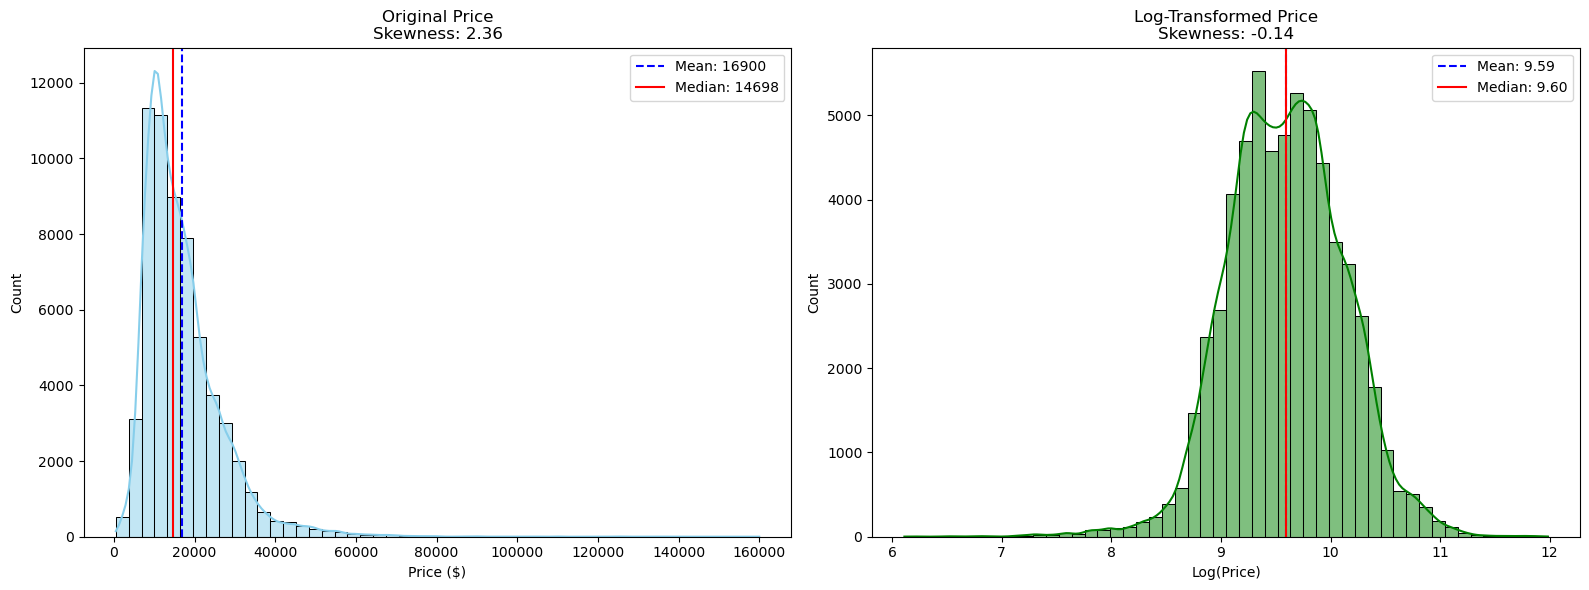

In [5]:
# Calculate Log Transformation
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Create Side-by-Side Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original Distribution
sns.histplot(y_train, bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f"Original Price\nSkewness: {y_train.skew():.2f}")
axes[0].set_xlabel("Price ($)")
axes[0].axvline(y_train.mean(), color='blue', linestyle='--', label=f"Mean: {y_train.mean():.0f}")
axes[0].axvline(y_train.median(), color='red', linestyle='-', label=f"Median: {y_train.median():.0f}")
axes[0].legend()

# Plot 2: Log-Transformed Distribution
sns.histplot(y_train_log, bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title(f"Log-Transformed Price\nSkewness: {y_train_log.skew():.2f}")
axes[1].set_xlabel("Log(Price)")
axes[1].axvline(y_train_log.mean(), color='blue', linestyle='--', label=f"Mean: {y_train_log.mean():.2f}")
axes[1].axvline(y_train_log.median(), color='red', linestyle='-', label=f"Median: {y_train_log.median():.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

We visualize the original `price` distribution alongside the transformed `log(price)` to demonstrate the impact of this optimization.

* **Original Distribution (Left):** Shows a severe **right-skew**. The mean is pulled significantly higher than the median by a "long tail" of luxury vehicles. This caused our baseline Lasso model to over-penalize errors on expensive cars, destabilizing the gradient.
* **Log-Transformed Distribution (Right):** Applying `np.log1p` successfully compresses the long tail. The distribution is now nearly **normal**, with the mean and median almost perfectly aligned.

By training our new models on the log-scale, we achieve three critical improvements:

* **Stabilized Variance:** Homoscedasticity is improved, satisfying core assumptions for linear-based baselines and helping tree-based models split more effectively on "average" cars rather than just the most expensive ones.
* **Outlier Robustness:** The transformation reduces the leverage of extreme outliers (e.g., a £100k car becomes ~11.5 on log scale), preventing them from dominating the loss function.
* **Metric Alignment:** Since we care about relative error (percentage difference) as much as absolute error, optimizing in log-space inherently minimizes the relative deviation.

*Note: All final predictions will be reversed to return them to the original currency scale for evaluation.*

## 6 - EDA (Exploratory Data Analysis)

Now that we have analyzed our target variable price, we must do the same for our predictor features. For that, we will split this section into two sub-sections:

* __Univariate Analysis:__ Understand the distribution, skew, and outliers of each feature individually. This substantiates our imputation and scaling strategies.

* __Multivariate Analysis:__ Understand how the features relate to each other and to our target variable log_price. This is relevant for feature selection.

### 6.1 - Univariate Analysis

In this section, we will examine each feature in the dataset in isolation, without regard to other variables or the target (price).

The primary goals of this analysis are:

* __Understand Feature Characteristics:__ To assess the central tendency (mean, median), dispersion (standard deviation, range), and the overall shape of the distribution for every numeric feature.

* __Diagnose Data Quality:__ To visually confirm the issues identified in our preliminary checks, specifically the degree of skewness, the presence of outliers, and any remaining inconsistencies or illogical values within individual columns.

* __Inform Preprocessing:__ The results of the univariate analysis (particularly the distribution plots) will serve as the direct, data-driven evidence necessary to justify our detailed steps for feature transformation, cleaning, and encoding.

By systematically examining each variable, we ensure that our approach to cleaning and preprocessing is adequate to our dataset.

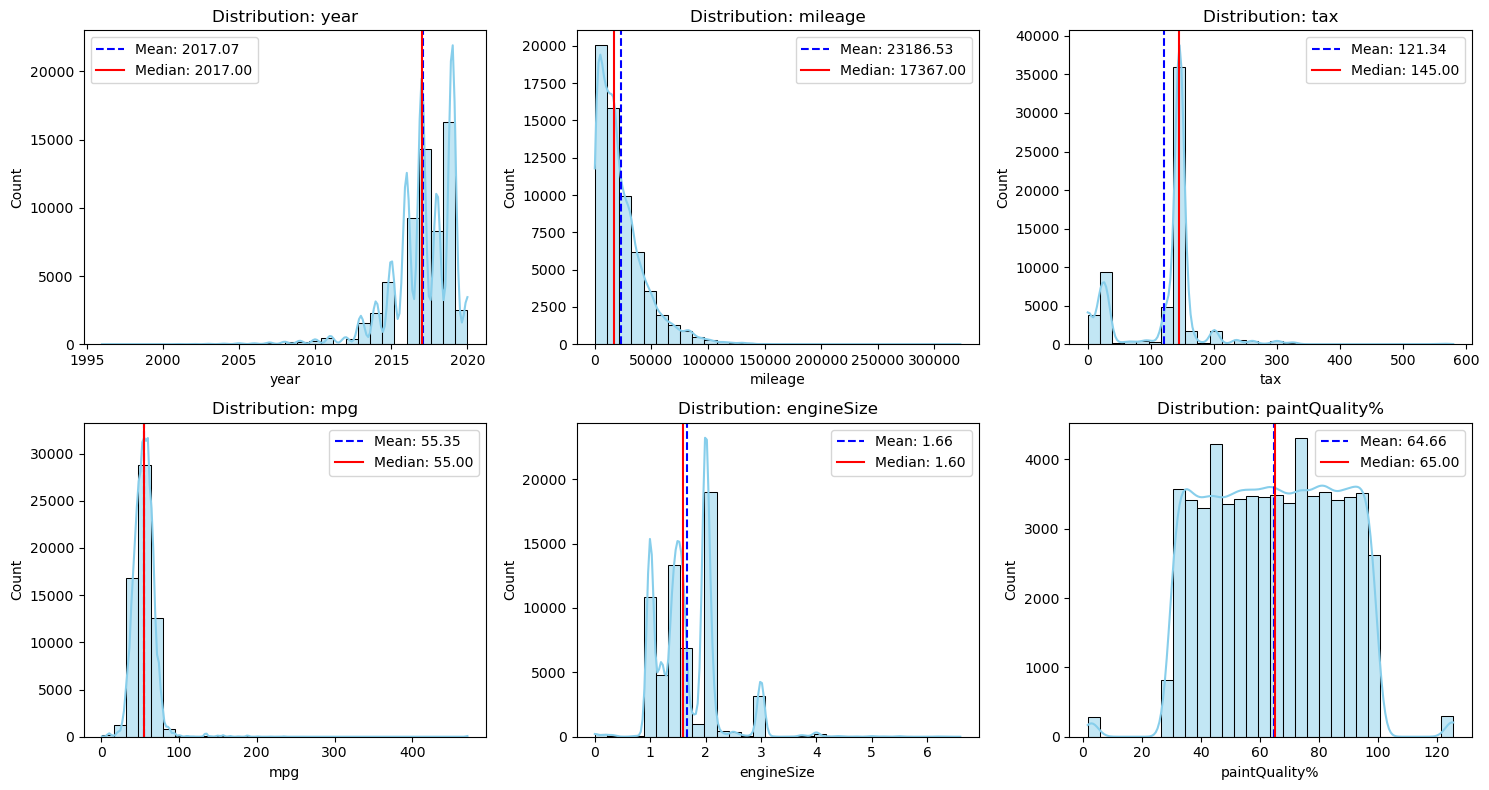

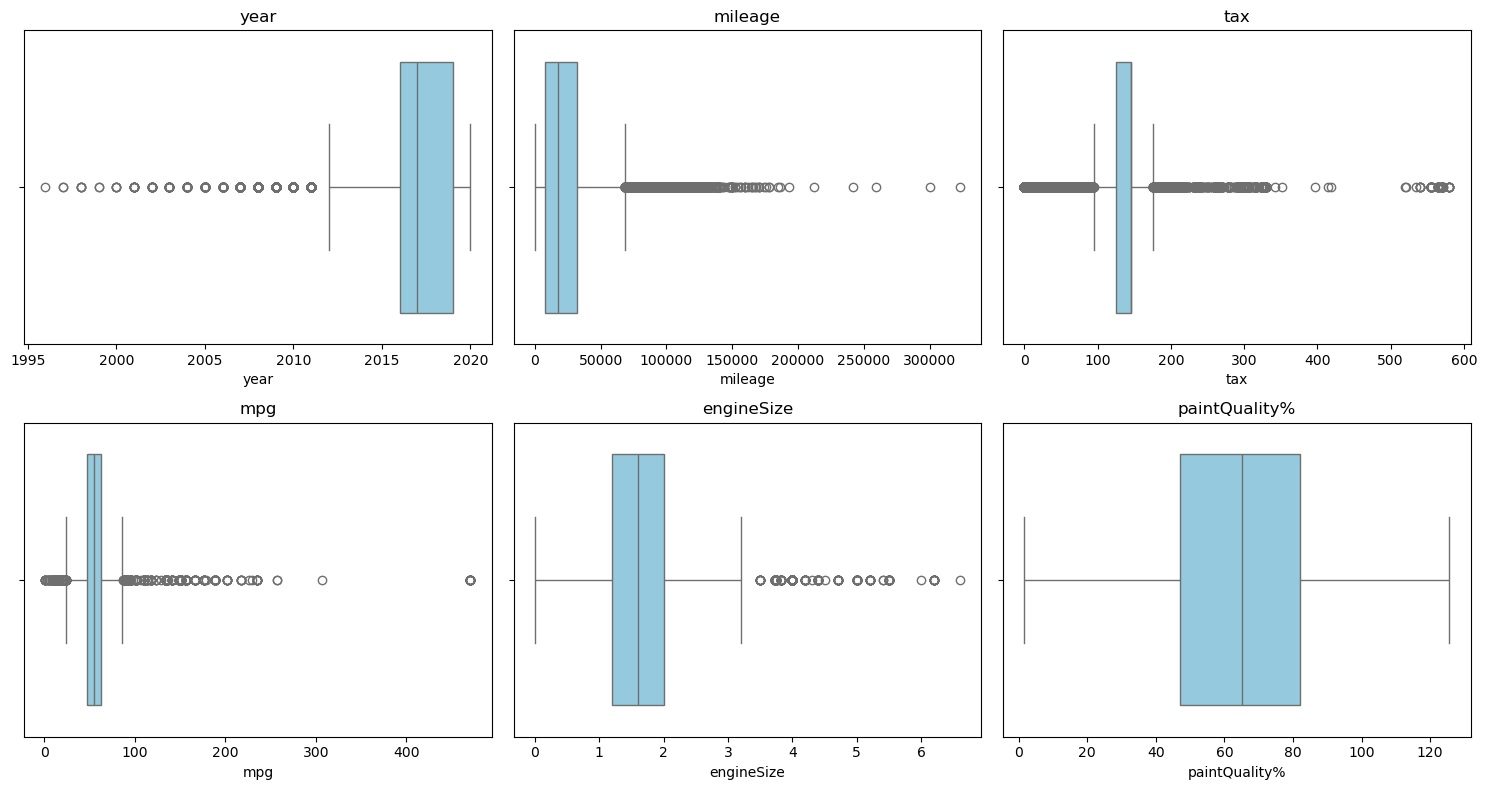

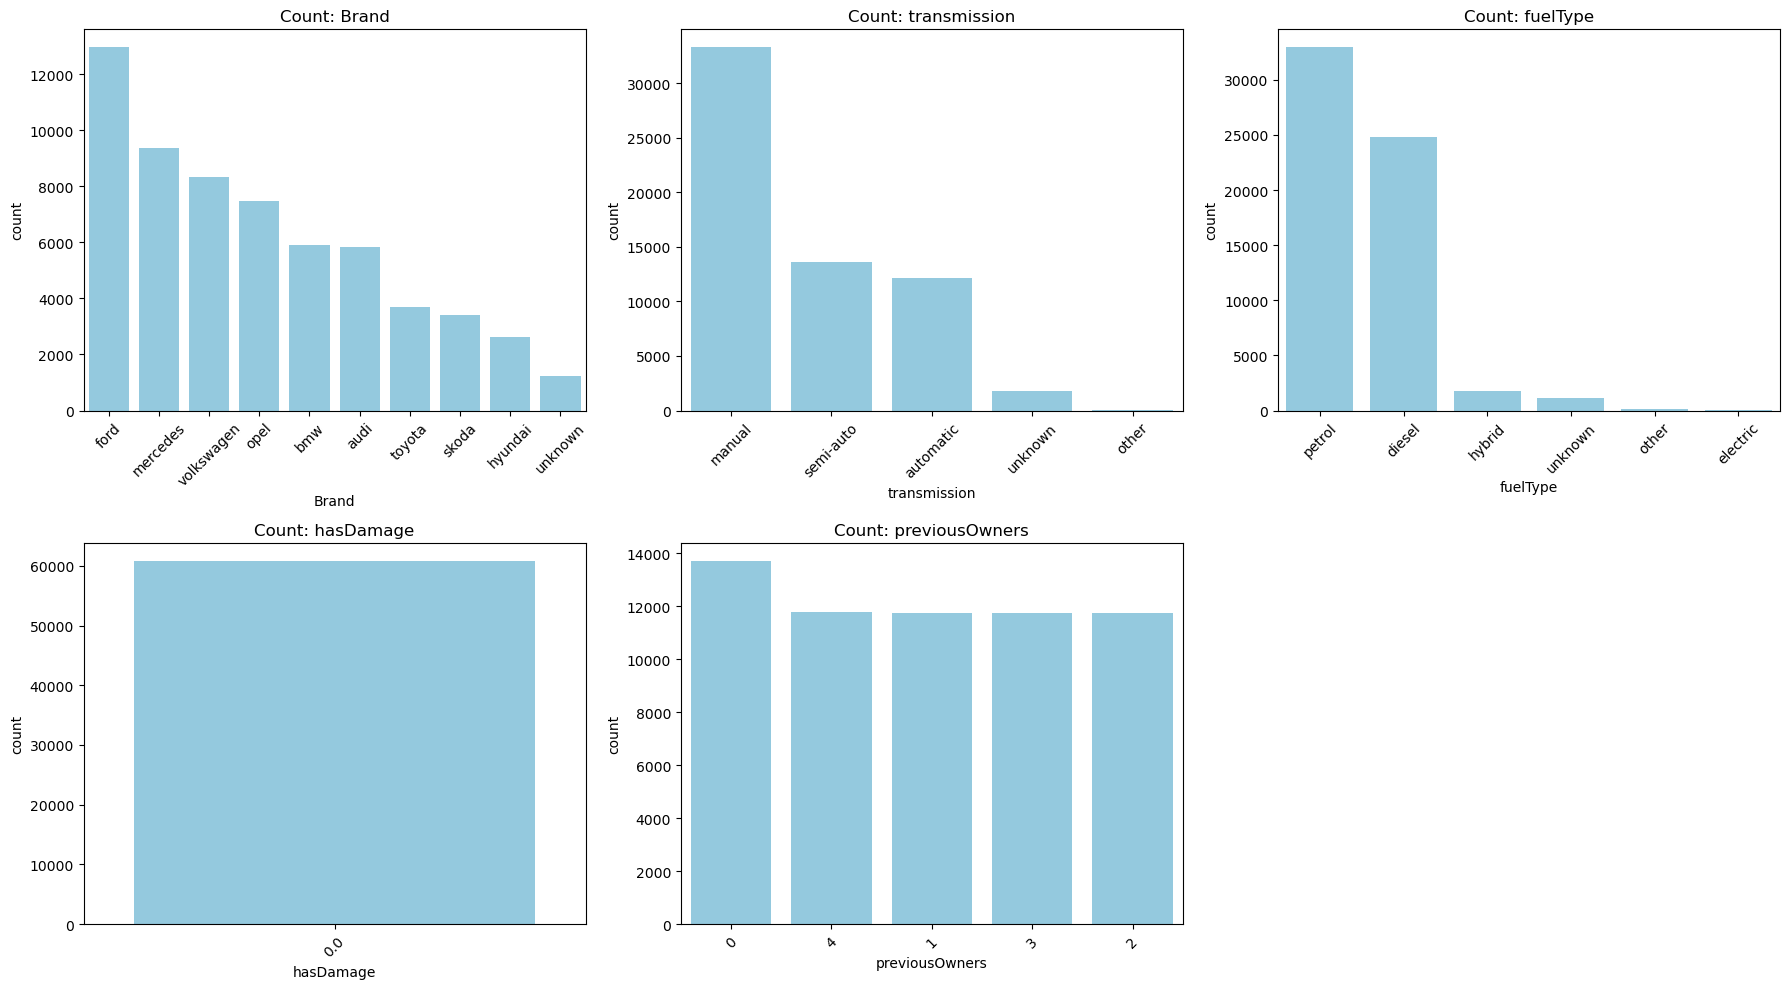

In [6]:
# --- 5. POST-CLEANING EDA (UNIVARIATE) ---

def plot_numerical_distributions(df, features):
    """Plots Histograms and Boxplots for numerical features."""
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    
    # 1. Histograms (Distribution)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(features):
        # Histogram in Skyblue
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='skyblue')
        
        # Calculate stats
        mean_val = df[col].mean()
        median_val = df[col].median()
        
        # Add Lines with Values in Label
        axes[i].axvline(mean_val, color='blue', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='red', linestyle='-', label=f'Median: {median_val:.2f}')
        
        axes[i].set_title(f'Distribution: {col}')
        axes[i].legend()
        
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

    # 2. Boxplots (Outliers)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(features):
        # Boxplot in Skyblue
        sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f'{col}')
        
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df, features):
    """Plots Countplots for categorical features."""
    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(features):
        # Countplot in Skyblue (No palette)
        order = df[col].value_counts().index[:15]
        sns.countplot(x=df[col], order=order, ax=axes[i], color='skyblue')
        
        axes[i].set_title(f'Count: {col}')
        axes[i].tick_params(axis='x', rotation=45)
        
    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
# Define feature groups
num_feats = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']
cat_feats = ['Brand', 'transmission', 'fuelType', 'hasDamage', 'previousOwners']

plot_numerical_distributions(X_train_final, num_feats)
plot_categorical_distributions(X_train_final, cat_feats)

From the plots generated above using our **clean** dataset (`X_train_final`), we can verify the effectiveness of our pipeline:

* __Data Integrity:__ There are no visible "impossible" values (e.g., negative mileage) or formatting errors. The distributions remain physically consistent with the original data, indicating that our imputation strategy (Median/KNN) did not introduce artificial distortion.
* __Label Standardization:__ The categorical plots confirm that typos (e.g., "vw" vs. "volkswagen") have been successfully merged into standard categories.

However, despite the clean data, the univariate analysis highlights three critical challenges we must address in the next phase:

* __Skewness problem:__ As seen in the histograms (particularly for `mileage` and `tax`), several predictors exhibit severe right-skewness and heavy tails. This non-normality is incompatible with the assumptions of linear regression. We must apply transformations (e.g., Log or Yeo-Johnson) to normalize these features.

* __Feature Engineering:__ To accurately model the economic factor of car ownership, we must move beyond the raw features. We recognize the need to create the `age` variable (from year) to directly quantify depreciation. Furthermore, exploring new variables, such as `mileage_per_year`, will enhance the model's ability to assess vehicle usage intensity.

* __Dimensionality Management for Stability:__ With categorical features now standardized, the high number of unique entries in features like `model` remains the primary structural challenge. To prevent feature explosion and model instability, we must finalize a strategy for dimensionality reduction. This involves techniques like grouping rare labels to efficiently encode categorical information without creating hundreds of sparse columns.

### 6.2 - Multivariate Analysis

In this section, we move beyond isolated variables to explore the interactions between our predictors and the target variable (`log_price`), as well as the relationships among the predictors themselves.

The primary objectives of this multivariate exploration are:
* **Establish Predictive Relationships:** To visually and statistically confirm the functional form of the relationship between our clean predictors (`X_train_final`) and the log-transformed price.
* **Identify Feature Importance:** To assess how different levels of categorical features (e.g., Brand, Transmission) impact the central tendency and variance of the price.
* **Detect Multicollinearity:** To quantify the correlation between our continuous predictor variables, informing our future feature selection strategy.

1. Correlation Matrix


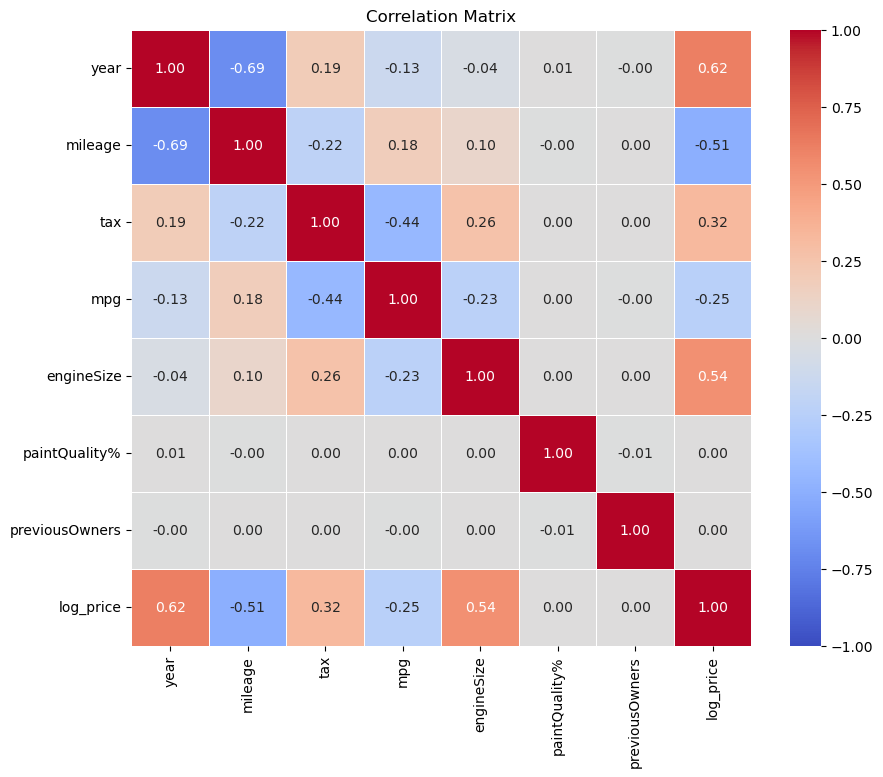


2. Numerical Scatter Plots (Linearity Check)


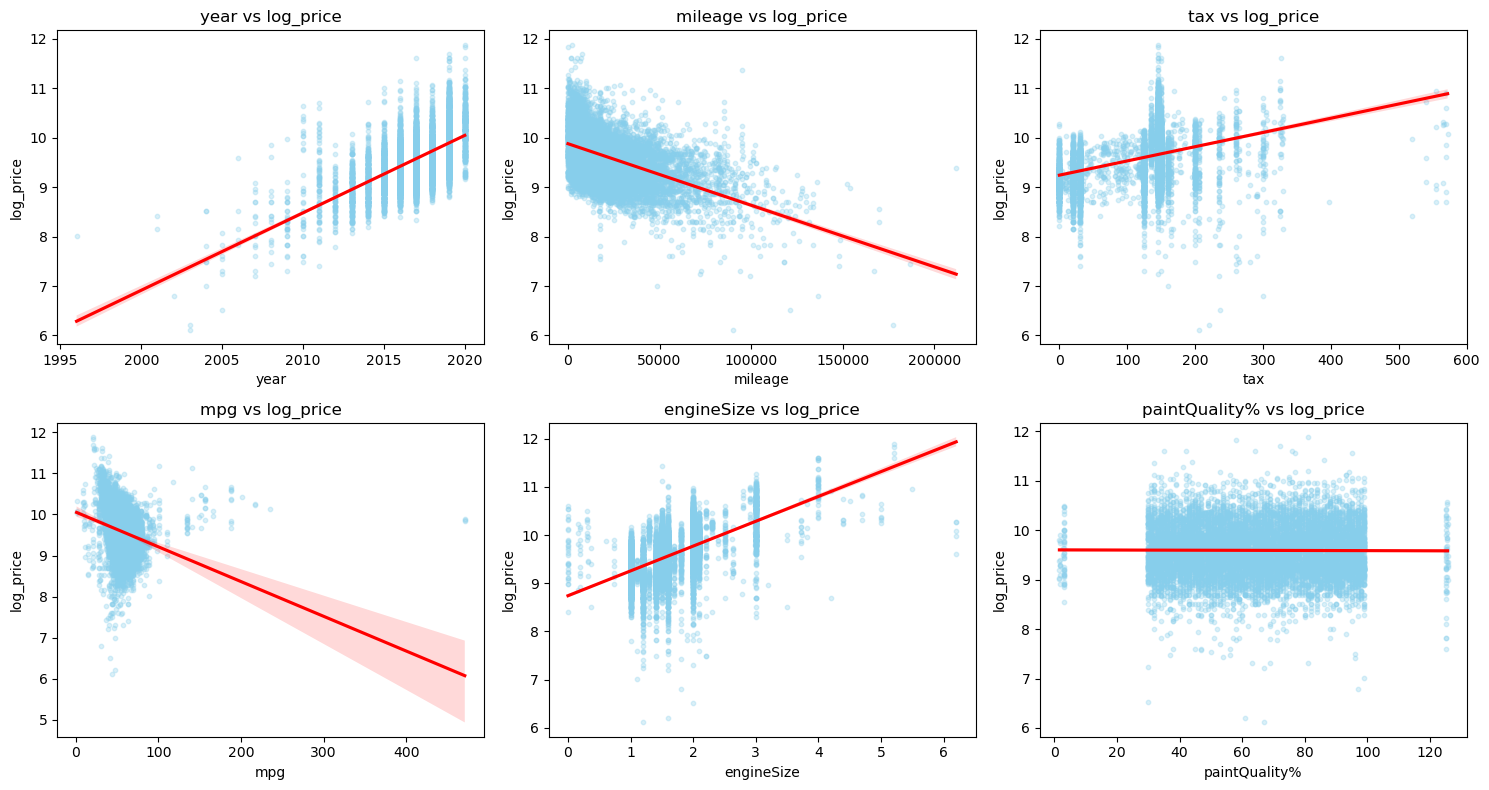


3. Categorical Box Plots (Variance Check)


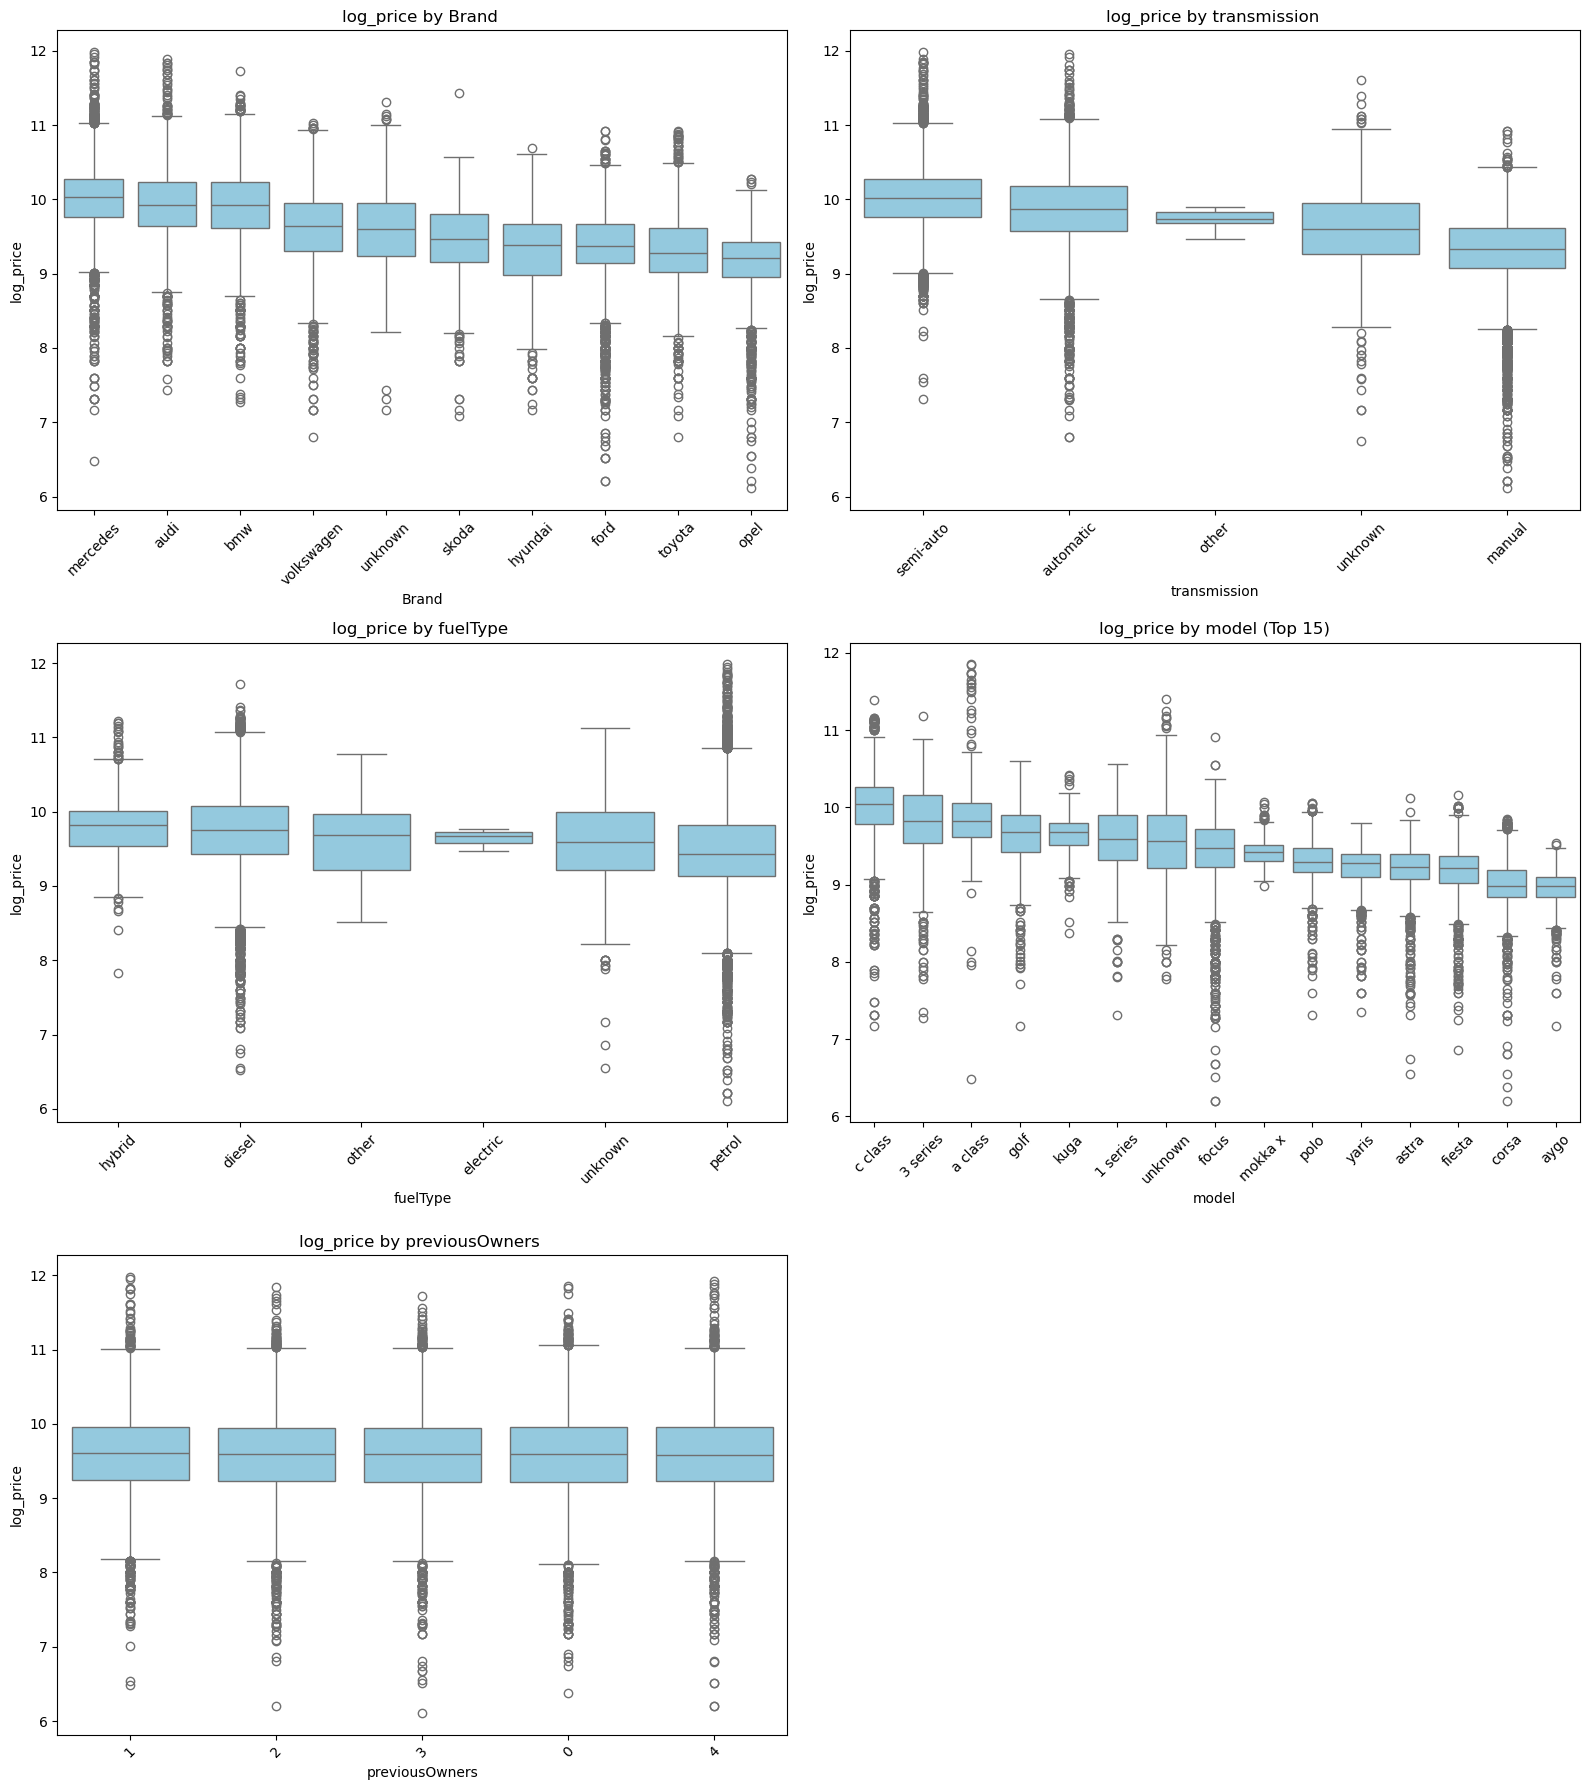

In [7]:
# Defining Functions for Multivariate Analysis

def plot_correlation_matrix(df, target, title="Correlation Matrix"):
    """
    Calculates and visualizes the Pearson correlation between features and the target.
    
    Purpose:
        To identify which numerical features have the strongest linear relationship 
        with the log_price. Check 'paintQuality%' specifically to see if it's noise.
    
    Args:
        df (pd.DataFrame): The dataframe containing numerical features (e.g., X_train_final).
        target (pd.Series): The target variable (e.g., y_train_log).
        title (str): Title of the chart.

    Returns:
        None: Displays a heatmap.
    """
    # Combine features and target into a temporary dataframe
    data = df.copy()
    data['log_price'] = target
    
    # Calculate Pearson Correlation
    corr = data.corr(method='pearson')
    
    # Plot Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
    plt.title(title)
    plt.show()

def plot_numerical_vs_target(df, target, features):
    """
    Generates Scatter Plots with a Regression Line (OLS) for each feature vs. target.
    
    Purpose:
        To visually assess linearity. 
        - If the red line fits the blue dots well, linear models might work.
        - If the points form a random cloud, the feature is likely noise.

    Args:
        df (pd.DataFrame): The dataframe containing numerical features.
        target (pd.Series): The target variable (log_price).
        features (list): List of column names to plot.
    """
    data = df[features].copy()
    data['log_price'] = target
    
    # Optimization: Downsample if dataset is massive (>10k rows) for speed
    if len(data) > 10000:
        data = data.sample(10000, random_state=42)

    n_cols = 3
    n_rows = (len(features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Scatter + Linear Regression Line
        sns.regplot(data=data, x=col, y='log_price', ax=axes[i], 
                    scatter_kws={'alpha':0.3, 's':10, 'color':'skyblue'}, 
                    line_kws={'color':'red'})
        axes[i].set_title(f'{col} vs log_price')

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

def plot_categorical_vs_target(df, target, features):
    """
    Generates Boxplots for categorical (or discrete) features vs. target.
    
    Purpose:
        To analyze price variance across groups.
        - Shows if different brands, fuel types, or owner counts have significantly different prices.

    Args:
        df (pd.DataFrame): The dataframe containing categorical features.
        target (pd.Series): The target variable (log_price).
        features (list): List of column names to plot.
    """
    data = df[features].copy()
    data['log_price'] = target
    
    n_cols = 2
    n_rows = (len(features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Handle High Cardinality (only plot Top 15 to keep it readable)
        if data[col].nunique() > 15:
            top_15 = data[col].value_counts().nlargest(15).index
            plot_data = data[data[col].isin(top_15)]
            title_suffix = "(Top 15)"
        else:
            plot_data = data
            title_suffix = ""

        # Order boxes by Median Price (Descending)
        order = plot_data.groupby(col)['log_price'].median().sort_values(ascending=False).index
        
        sns.boxplot(data=plot_data, x=col, y='log_price', order=order, ax=axes[i], color='skyblue')
        axes[i].set_title(f'log_price by {col} {title_suffix}')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


# EXECUTION PIPELINE

# 1. Define Features
available_num_feats = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%'] 

# Note: 'previousOwners' is included here to generate a Box Plot
available_cat_feats = ['Brand', 'transmission', 'fuelType', 'model', 'previousOwners']

# 2. Generate Plots
print("1. Correlation Matrix")
# We include 'previousOwners' in the heatmap to see its linear correlation
plot_correlation_matrix(X_train_final[available_num_feats + ['previousOwners']], y_train_log)

print("\n2. Numerical Scatter Plots (Linearity Check)")
plot_numerical_vs_target(X_train_final, y_train_log, available_num_feats)

print("\n3. Categorical Box Plots (Variance Check)")
plot_categorical_vs_target(X_train_final, y_train_log, available_cat_feats)

##### **Numerical Feature Analysis (Correlation & Linearity)**
The correlation matrix and scatterplots (generated above) reveal clear economic patterns:

* **Engine & Performance:** `engineSize` shows a strong positive correlation with price, indicating that larger, more powerful engines tend to be more expensive. `tax` also rises with price, likely acting as a proxy for emissions/engine class.
* **Usage & Depreciation:** Higher `mileage` correlates strongly with lower prices, confirming that wear-and-tear is a primary depreciation factor. `mpg` shows a negative link `log_price`, suggesting that fuel-efficient economy cars are generally cheaper.
* **Noise Detection:** Crucially, `paintQuality%` shows a near-flat regression line and negligible correlation. This confirms our hypothesis that this feature is likely synthetic noise with little predictive power.

##### **Categorical Feature Analysis (Price Variance)**
The boxplots reveal strong, consistent trends:

* **Brand Hierarchy:** Premium brands (Mercedes, Audi, BMW) show distinctly higher median `log_price` values compared to economy brands, confirming Brand as a major value driver.
* **Transmission & Fuel:** Automatic and Semi-Auto transmissions generally command higher prices than Manuals. Hybrids and Petrol engines also tend to outprice Diesels.
* **Ownership History:** Contrary to expectations, the `previousOwners` boxplot reveals no clear trend. The median price remains relatively stable regardless of the number of previous owners. Additionally, it shows negligible correlation with `log_price` suggesting this feature may not be a strong differentiator in this specific dataset.

##### **Conclusion**
The relationships observed are generally statistically significant and economically sound. The strong signals in `engineSize`, `Brand`, and `mileage` confirm they will be key drivers for our model. However, both `paintQuality%` and `previousOwners` appear to be weak predictors or noise, making them prime candidates for removal during the Feature Selection phase.

## 7 - Feature Engineering

We now perform feature engineering — a crucial step for maximizing model performance by transforming raw, observed variables into features with higher explanatory power. Our goal is to move beyond the raw columns and capture the logical relationships that actually drive market value.

##### **Engineered Features**

* **Age (Depreciation):**
From a business perspective, a car's `year` is less relevant than its cumulative depreciation. Price is mainly affected by how *old* the car is at the time of sale.
Therefore, we transform the `year` column into `age` by subtracting it from the database reference year (2020).


* **Mileage Per Year (Usage Intensity):**
Total mileage alone does not give a full picture of a car's condition. A 10-year-old car with 100k miles is normal; a 2-year-old car with 100k miles is a "high-intensity" vehicle with likely significant wear.
Therefore, we create `mileage_per_year` ($\frac{\text{Total Mileage}}{\text{Age}}$) to quantify usage intensity.
It is worth noting that, for brand new cars (age = 0), mathematical division would cause an error, for what we implemented a logical check to handle these cases - setting their `mileage_per_year` equal to their total mileage (since they are in their first year of life).

##### **Implementation Strategy**
To maintain pipeline integrity, these transformations are encapsulated in a reusable function (engineer_features). This ensures that the exact same logic is applied to both the Training and Validation sets, preventing any feature skew between the two.

In [8]:
# Define Feature Engineering Function
def engineer_features(df):
    """
    Creates new predictive features from existing columns.
    
    Purpose:
        To improve model performance by adding domain-specific features.
        - 'age': Direct measure of depreciation (2020 - year).
        - 'mileage_per_year': Measure of usage intensity (mileage / age).
        
    Args:
        df (pd.DataFrame): The clean dataframe (X_train_final or X_val_final).
        
    Returns:
        pd.DataFrame: A new dataframe with the added 'age' and 'mileage_per_year' columns.
    """
    df = df.copy()
    
    # Reference year from the project guidelines (Database is from 2020)
    REFERENCE_YEAR = 2020
    
    # 1. Create Age
    # We clip at 0 to prevent negative age
    df['age'] = (REFERENCE_YEAR - df['year']).clip(lower=0)
    
    # 2. Mileage per Year
    # If age is 0 (new car), usage intensity is effectively the total mileage so far.
    # We use np.where to handle the division by zero safely.
    df['mileage_per_year'] = np.where(
        df['age'] > 0, 
        df['mileage'] / df['age'], 
        df['mileage']
    )
    
    return df

# Execution
# Create new variables for the engineering phase (to not overwrite clean data)
X_train_eng = engineer_features(X_train_final)
X_val_eng = engineer_features(X_val_final)

print(X_train_eng[['year', 'age', 'mileage', 'mileage_per_year']].head())

       year  age  mileage  mileage_per_year
carID                                      
17712  2018    2  25943.0      12971.500000
60272  2018    2  28993.0      14496.500000
54409  2014    6  66158.0      11026.333333
60966  2017    3  22759.0       7586.333333
2891   2018    2   4847.0       2423.500000
